# Inverse design of bimaterial LCE lattice: long strip


## Imports

In [3]:
from morphing_lattices.optimization import ForwardProblem, OptimizationProblem
from morphing_lattices.structure import Lattice, ControlParams
from morphing_lattices.geometry import triangular_lattice_points, triangular_lattice_connectivity
from morphing_lattices.plotting import plot_lattice
import pandas as pd
import jax.numpy as jnp
from jax._src.config import config
config.update("jax_enable_x64", True)  # enable float64 type
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use(["science", "grid"])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Import experimental material params


In [4]:
exp_actuation_strain = pd.read_csv(
    '../exp/mechanical_data/20230512_HTNI_LTNI_actuationstrains_highgranularityTemp3355.csv'
).drop(['Unnamed: 3'], axis=1)
exp_modulus_fine = pd.read_csv(
    '../exp/mechanical_data/youngs_mod_LCEstrips_DataForBertoldiGroup_updated202307.csv'
)
exp_modulus_fine.columns = [
    'Temp',
    'LTNI_avg_young',
    'LTNI_stdev',
    'HTNI_avg_young',
    'HTNI_stdev',
]
exp_modulus_fine.drop([0, 1], inplace=True)
exp_modulus_fine = exp_modulus_fine.reset_index(drop=True)

HTNI_stretch_data = exp_actuation_strain[
    ['temp [C]', 'AVG HTNI', 'STD HTNI']
].astype(float)
LTNI_stretch_data = exp_actuation_strain[
    ['temp [C]', 'AVG LTNI', 'STD LTNI']
].astype(float)
HTNI_modulus_data_fine = exp_modulus_fine[
    ['Temp', 'HTNI_avg_young']
].astype(float)
LTNI_modulus_data_fine = exp_modulus_fine[
    ['Temp', 'LTNI_avg_young']
].astype(float)


def HTNI_stretch(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_stretch_data['temp [C]']), jnp.array(HTNI_stretch_data['AVG HTNI']))


def LTNI_stretch(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_stretch_data['temp [C]']), jnp.array(LTNI_stretch_data['AVG LTNI']))


def HTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data_fine['Temp']), jnp.array(HTNI_modulus_data_fine['HTNI_avg_young']))


def LTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data_fine['Temp']), jnp.array(LTNI_modulus_data_fine['LTNI_avg_young']))

## Optimization problem

### Temperature evolution

In [5]:
# NOTE: Ask Audrey about the 22C data point
sampled_temperatures = jnp.array([
    22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130
])

simulation_time = 9000.  # s
sampled_times = jnp.linspace(0, simulation_time, sampled_temperatures.shape[0])


def temperature_fn(t):
    return jnp.interp(t, sampled_times, sampled_temperatures)


def young_1_fn(t):
    return HTNI_young_fit_fine(temperature_fn(t))


def young_2_fn(t):
    return LTNI_young_fit_fine(temperature_fn(t))


def thermal_strain_1_fn(t):
    return (HTNI_stretch(temperature_fn(t))-1.)*0.8


def thermal_strain_2_fn(t):
    return (LTNI_stretch(temperature_fn(t))-1.)*0.7

### Forward problem

(<Figure size 1200x300 with 1 Axes>,
 <Axes: title={'center': 'Lattice'}, xlabel='$x$', ylabel='$y$'>)

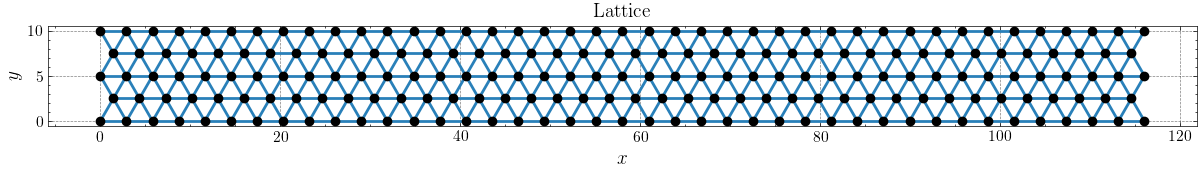

In [6]:
n1 = 40
n2 = 4
spacing = 2.9  # mm
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(
    n1=n1,
    n2=n2
)

n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,  # mm
    young=jnp.ones(n_bonds),  # MPa
    area=jnp.ones(n_bonds)*(4*0.125**2),  # mm^2
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.03*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
    # NOTE: This is the initial guess for the material distribution
    phase=jnp.linspace(0, 1, n_bonds),  # NOTE: 0 means HTNI, 1 means LTNI
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
problem = ForwardProblem(
    lattice=lattice,
    simulation_time=simulation_time,
    n_timepoints=sampled_temperatures.shape[0],
)
problem.setup(
    young_1_fn=young_1_fn,
    young_2_fn=young_2_fn,
    thermal_strain_1_fn=thermal_strain_1_fn,
    thermal_strain_2_fn=thermal_strain_2_fn,
)
plot_lattice(lattice=lattice, figsize=(12, 3))

### Optimization


#### Target points

In [ ]:
# TODO: Implement better way to specify target points
target_points_ids = jnp.arange(81, 122)
target_points = lattice.control_params.reference_points[target_points_ids] + jnp.array([
    jnp.linspace(1, -1, target_points_ids.shape[0])*20,
    jnp.sin(jnp.linspace(0, 2*jnp.pi, target_points_ids.shape[0]))*10
]).T

(16.2, 99.8, -5.9770526580502565, 16.022947341949745)

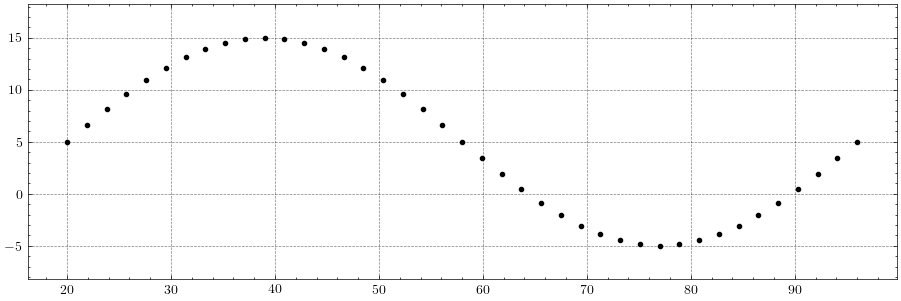

In [10]:
plt.figure(figsize=(9, 3), constrained_layout=True)
plt.plot(target_points[:, 0], target_points[:, 1],
         'o', color='k', markersize=3)
plt.axis('equal')

In [11]:
optimization = OptimizationProblem(
    forward_problem=problem,
    target_points=target_points,
    target_points_ids=target_points_ids,
)

### Run optimization


In [12]:
optimization.run_optimization_nlopt(
    n_iterations=50,
    # max_time=60,
    lower_bound=0.,
    upper_bound=1.,
)

Iteration: 1
Objective = 2244.7042371234775
MMA dual converged in 2 iterations to g=2099.38:
Iteration: 2
Objective = 1995.150557506619
MMA outer iteration: rho -> 0.1
MMA dual converged in 2 iterations to g=1843.46:
Iteration: 3
Objective = 1543.5918094956066
MMA outer iteration: rho -> 0.01
                 MMA sigma[0] -> 0.5
MMA dual converged in 2 iterations to g=1405.21:
Iteration: 4
Objective = 1343.9955947402316
MMA outer iteration: rho -> 0.001
                 MMA sigma[0] -> 0.5
MMA dual converged in 2 iterations to g=1121.18:
Iteration: 5
Objective = 1266.801139556027
MMA inner iteration: rho -> 0.01
MMA dual converged in 2 iterations to g=1175.81:
Iteration: 6
Objective = 1264.513275420775
MMA inner iteration: rho -> 0.1
MMA dual converged in 2 iterations to g=1114.98:
Iteration: 7
Objective = 1231.4153867212217
MMA inner iteration: rho -> 1
MMA dual converged in 2 iterations to g=1202.37:
Iteration: 8
Objective = 1208.3541659091316
MMA inner iteration: rho -> 1.89305
MMA 

(<Figure size 1200x400 with 2 Axes>,
 <Axes: title={'center': 'Lattice'}, xlabel='$x$', ylabel='$y$'>)

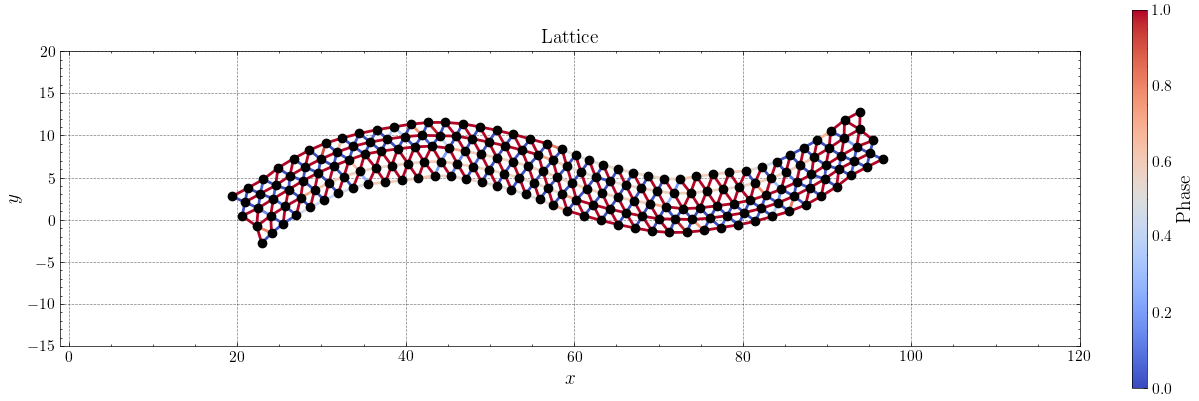

In [20]:
plot_lattice(
    lattice=lattice,
    displacement=optimization.best_response[-1, 0],
    bond_values=optimization.best_control_params.phase,
    figsize=(12, 4),
    xlim=(-1, 120),
    ylim=(-15, 20),
    legend_label="Phase",
)